In [1]:
from glob import glob
from find_z import find_z, load_generator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import v2

from sklearn.manifold import TSNE

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [2]:
ALIGNED_FOLDER = "/media/pawel/DATA/tmp/freddie_mercuries/en_face/aligned"
get_coordinates = lambda position, extreme: "55555"[:position] + str(extreme) + "55555"[position+1:]
extremes_coordinates = [get_coordinates(p, e) for e in (0, 9) for p in range(4, -1, -1)]
paths = [glob(f"{ALIGNED_FOLDER}/*head_genes_00000{coord}.jpg")[0] for coord in extremes_coordinates]

In [3]:
IMG_SIZE = 256
DEVICE = "cuda:0"

def prep_image(filename)-> torch.tensor:
    image = Image.open(filename).convert("RGB")
    image_min_size = min(image.size)
    transforms = v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_min_size),
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True)
    ])
    return transforms(image).to(DEVICE)


def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()

def show_tensor_picture(tensor, title=""):
    im_arr = prep_tensor_to_show(tensor)
    plt.title(title)
    plt.axis("off")
    plt.imshow(im_arr)
    

def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4], row_titles=None):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow((images[i]).reshape(images[idx].shape[0], images[idx].shape[1]))
        else:
            ax.imshow((images[idx]))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
      
    if row_titles:  
        for ax, row in zip(axes[:, 0], row_titles):
            ax.axis("on")
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel(row, size=12, rotation=90, labelpad=10)
            ax.get_yaxis().set_ticks([])
            ax.get_xaxis().set_ticks([])
            
    fig.suptitle(title, size=16)
    plt.tight_layout()
    # plt.savefig(f"{title}.png")
    plt.show()
    

In [6]:
min_imgs, max_imgs = torch.from_numpy(np.array([prep_image(img).cpu() for img in paths[:5]])).to(device=DEVICE), torch.from_numpy(np.array([prep_image(img).cpu() for img in paths[5:]])).to(device=DEVICE)

In [7]:
# z_min, z_max = find_z(min_imgs), find_z(max_imgs)
z_min, z_max = torch.load('z_min.pth'), torch.load('z_max.pth')

In [35]:
# # z_min[0, :] = find_z(min_imgs[0].unsqueeze(0))
# torch.save(z_min, "z_min.pth")
# torch.save(z_max, "z_max.pth")


In [13]:
generator = load_generator()


In [ ]:

for min_img, max_img, z_min_infered, z_max_infered in zip(min_imgs, max_imgs, z_min, z_max):
    z = torch.stack([z_min_infered, z_max_infered]).to(DEVICE)
    with torch.no_grad():
        generated = generator(z)
    plot_images([prep_tensor_to_show(min_img), prep_tensor_to_show(generated[0]),  prep_tensor_to_show(max_img), prep_tensor_to_show(generated[1])],
                ["Min original",  "Min infered", "Max original", "Max infered"],
                2, 2, title="Original vs infered", figsize=[8, 8])

### Infer

In [12]:
def slerp(low, high, val):
    """Spherical linear interpolation between two points on a unit sphere.
    
    Args:
        p0 (numpy.ndarray): Starting point on the unit sphere.
        p1 (numpy.ndarray): Ending point on the unit sphere.
        t (float): Interpolation parameter between 0 and 1.
        
    Returns:
        numpy.ndarray: Interpolated point on the unit sphere.
    """
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
    # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def generate_intermediate_vectors_sphere(a_vec, b_vec, n):
    ratios = np.linspace(0, 1, n)
    return [ slerp(a_vec, b_vec, ratio) for ratio in ratios]

def generate_intermediate_vectors(a_vec, b_vec, n):
    ratios = np.linspace(0, 1, n)
    return [a_vec + ratio * (b_vec - a_vec) for ratio in ratios]

N_INTERMEDIATE = 7
features_labels = ['Eye distance', 'Eye height', 'Eye angle', 'Jaw width', 'Jaw height']

In [88]:
a = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
b = np.array([0.7, 0.3, 0.6, .2, .9])
generate_intermediate_vectors(a, b, N_INTERMEDIATE)

[array([0.1, 0.1, 0.1, 0.1, 0.1]),
 array([0.2       , 0.13333333, 0.18333333, 0.11666667, 0.23333333]),
 array([0.3       , 0.16666667, 0.26666667, 0.13333333, 0.36666667]),
 array([0.4 , 0.2 , 0.35, 0.15, 0.5 ]),
 array([0.5       , 0.23333333, 0.43333333, 0.16666667, 0.63333333]),
 array([0.6       , 0.26666667, 0.51666667, 0.18333333, 0.76666667]),
 array([0.7, 0.3, 0.6, 0.2, 0.9])]

In [89]:
generate_intermediate_vectors_sphere(a, b, N_INTERMEDIATE)

[array([0.1, 0.1, 0.1, 0.1, 0.1]),
 array([0.2046901 , 0.13583206, 0.18747559, 0.11861755, 0.23911911]),
 array([0.30825359, 0.17091651, 0.27391932, 0.13658223, 0.37692214]),
 array([0.41012048, 0.20506024, 0.35885542, 0.15379518, 0.51265061]),
 array([0.50973011, 0.23807534, 0.44181642, 0.17016165, 0.64555749]),
 array([0.60653421, 0.2697801 , 0.52234568, 0.18559157, 0.77491127]),
 array([0.7, 0.3, 0.6, 0.2, 0.9])]

In [90]:
z_intermediates = [generate_intermediate_vectors(z_min_infered, z_max_infered, N_INTERMEDIATE) for z_min_infered, z_max_infered in zip(z_min, z_max)]
print(z_intermediates[0][0].shape)

torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


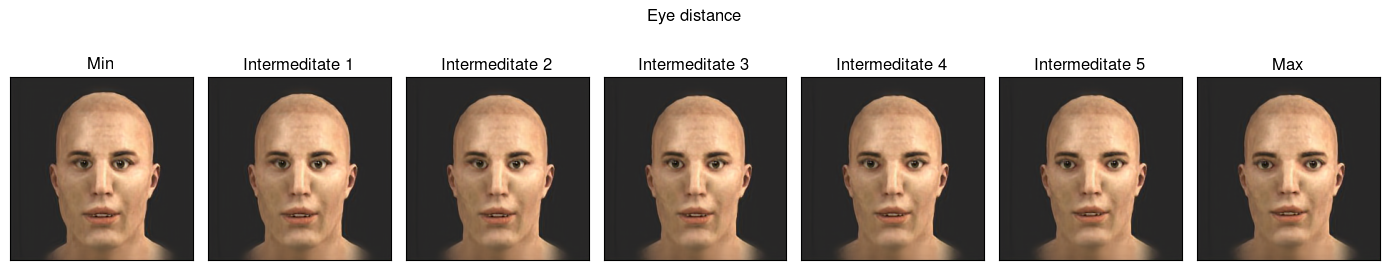

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


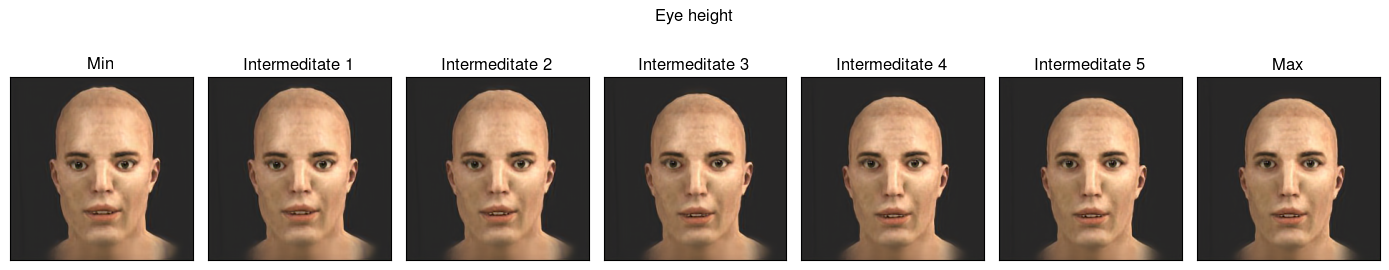

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


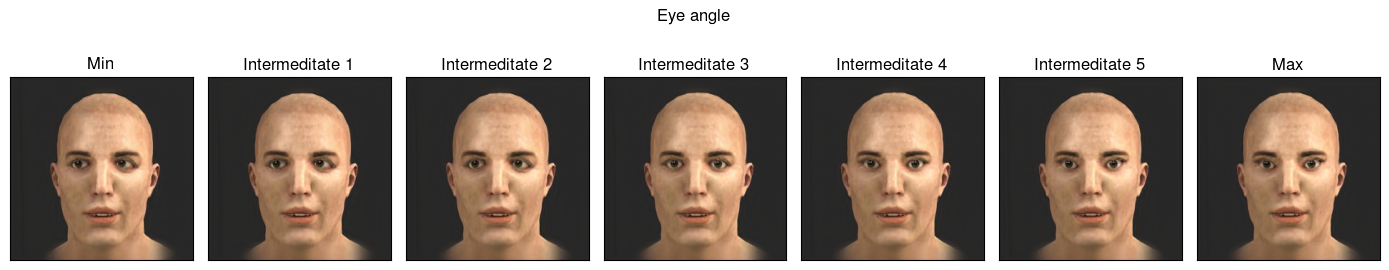

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


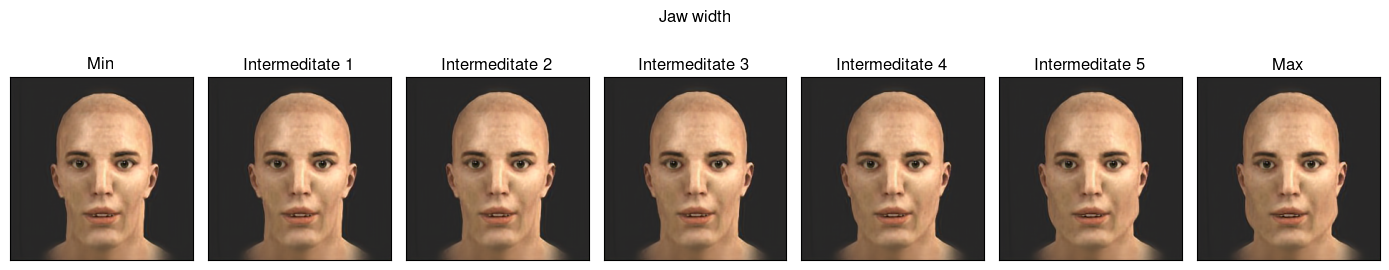

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


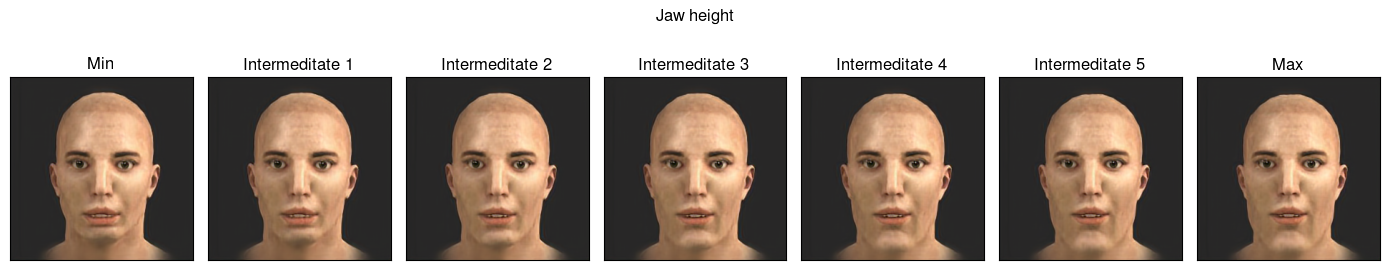

In [91]:
for intermediate_zs, title in zip(z_intermediates, features_labels):
    generated_intermediates = []
    for z in intermediate_zs:
        with torch.no_grad():
            z_to_generator = z.unsqueeze(0).to(DEVICE)
            generated_intermediates.append(generator(z_to_generator)[0])
            
    plot_images([prep_tensor_to_show(img) for img in generated_intermediates],
                ["Min"] + [f"Intermeditate {i}" for i in range(1, N_INTERMEDIATE-1)] + ["Max"],
                1, N_INTERMEDIATE, title=title, figsize=[(N_INTERMEDIATE)*2, 3])
    

35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

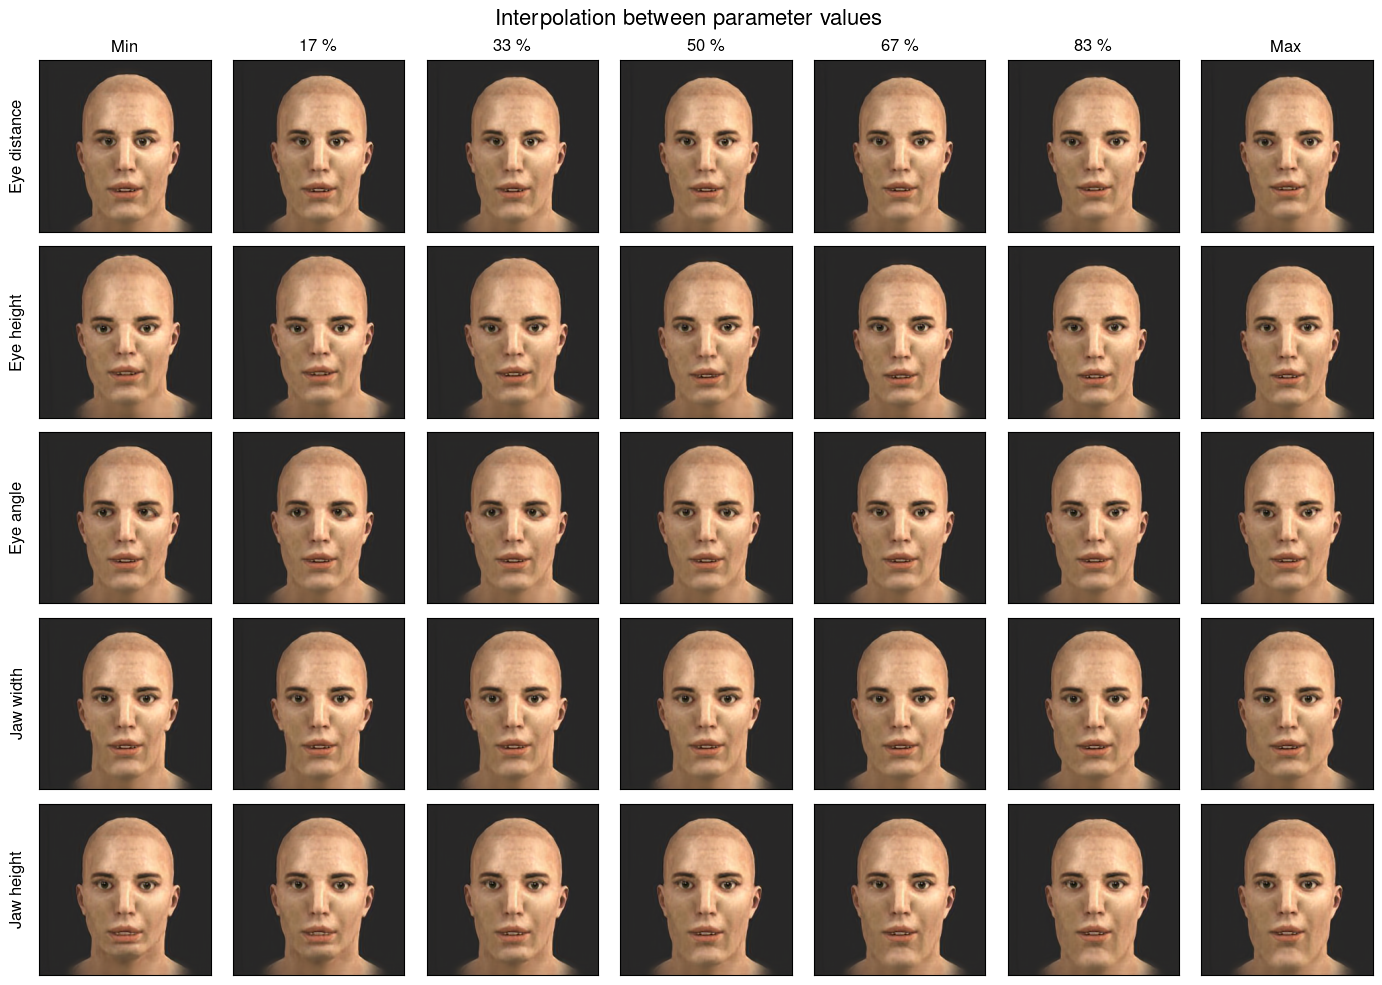

In [100]:
generated_intermediates = []
for intermediate_zs in z_intermediates:
    for z in intermediate_zs:
        with torch.no_grad():
            z_to_generator = z.unsqueeze(0).to(DEVICE)
            generated_intermediates.append(generator(z_to_generator)[0])
  
print(len(generated_intermediates))
            
plot_images([prep_tensor_to_show(img) for img in generated_intermediates],
            ["Min"] + [f"{round(100*i*(1./(N_INTERMEDIATE-1)))} \%" for i in range(1, N_INTERMEDIATE-1)] + ["Max"] + 4*N_INTERMEDIATE*[''],
            5, N_INTERMEDIATE, title="Interpolation between parameter values", figsize=[N_INTERMEDIATE*2, 5*2], row_titles=features_labels)
    

35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

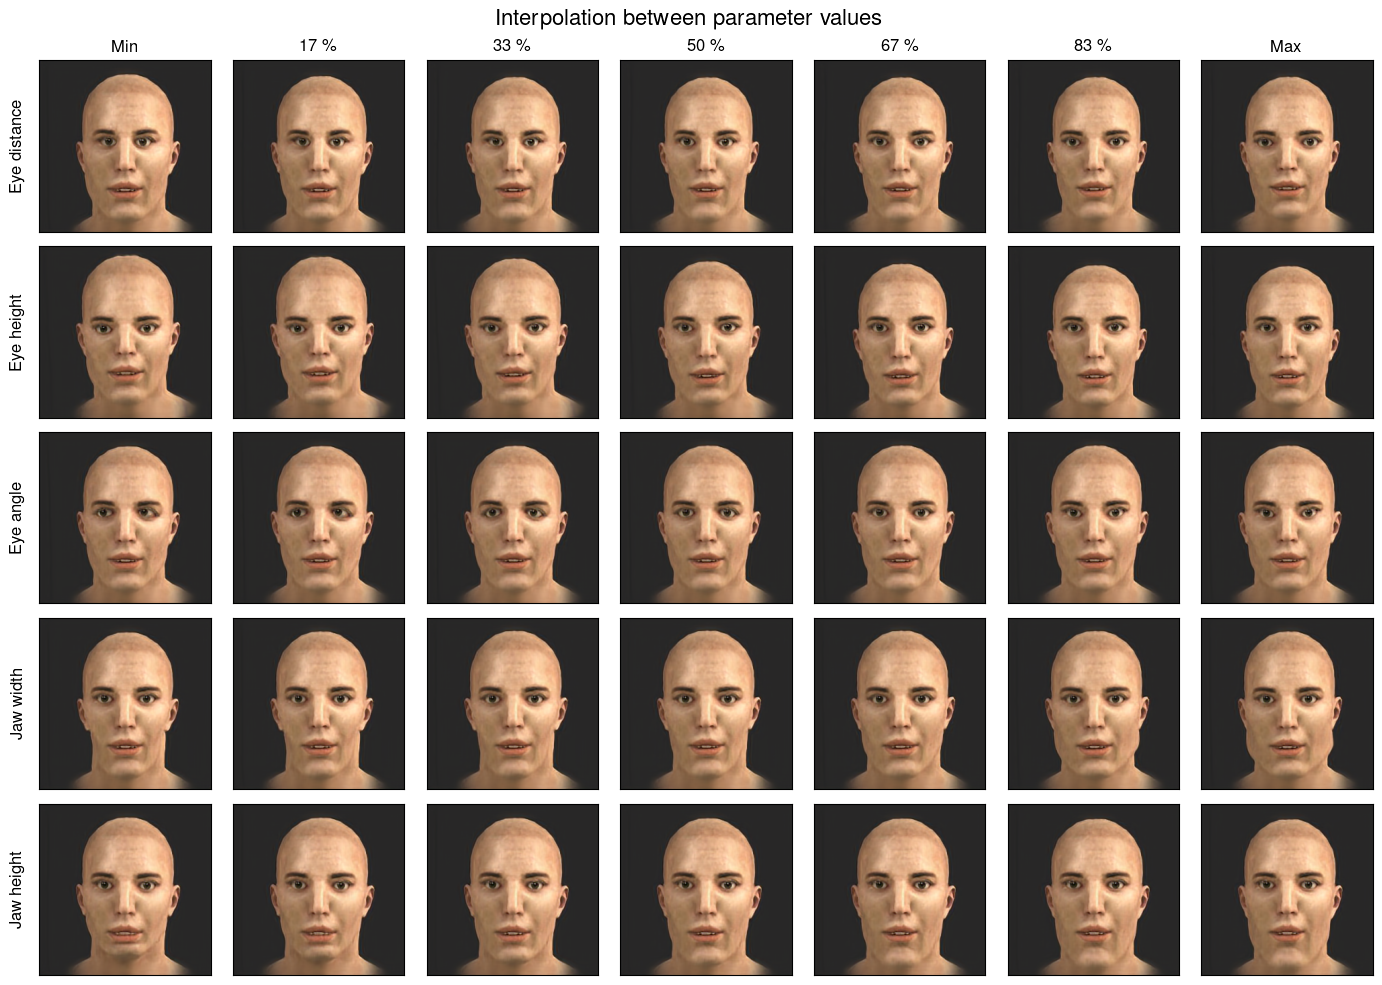

In [101]:
z_intermediates = [generate_intermediate_vectors_sphere(z_min_infered, z_max_infered, N_INTERMEDIATE) for z_min_infered, z_max_infered in zip(z_min, z_max)]

generated_intermediates = []
for intermediate_zs in z_intermediates:
    for z in intermediate_zs:
        with torch.no_grad():
            z_to_generator = z.unsqueeze(0).to(DEVICE)
            generated_intermediates.append(generator(z_to_generator)[0])
  
print(len(generated_intermediates))
            
plot_images([prep_tensor_to_show(img) for img in generated_intermediates],
            ["Min"] + [f"{round(100*i*(1./(N_INTERMEDIATE-1)))} \%" for i in range(1, N_INTERMEDIATE-1)] + ["Max"] + 4*N_INTERMEDIATE*[''],
            5, N_INTERMEDIATE, title="Interpolation between parameter values", figsize=[N_INTERMEDIATE*2, 5*2], row_titles=features_labels)


In [112]:
np.array(z_intermediates).reshape(-1, 256).shape

(35, 256)

In [113]:
z_intermediates_np = np.array(z_intermediates).reshape(-1, 256)
z_embedd = TSNE(n_components=2).fit_transform(z_intermediates_np)
embeddings = z_embedd.reshape(5, 7, 2)

# for z_vectors in z_intermediates:
#     z_np_array = np.array(z_vectors)
    
#     print(f"Before TSNE: {z_np_array.shape}")
#     z_embedd = TSNE(n_components=2).fit_transform(z_np_array)
#     print(f"After TSNE: {z_embedd.shape}")
#     embeddings.append(z_embedd)


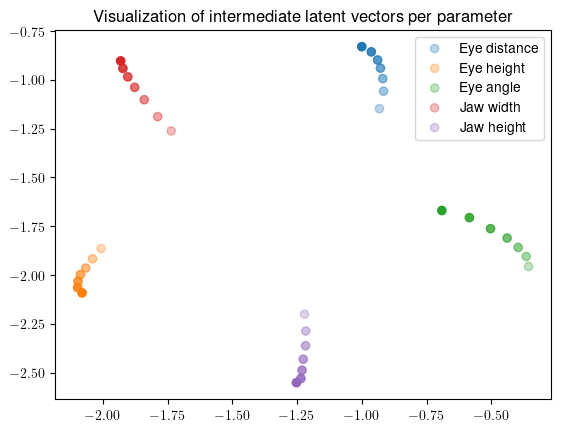

In [121]:
for embedding, label in zip(embeddings, features_labels):
    plt.scatter(embedding[:, 0], embedding[:, 1], label=label, alpha=np.linspace(0.3, 1, 7))

plt.legend()
plt.title("Visualization of intermediate latent vectors per parameter")
plt.show()
    

['/media/pawel/DATA/tmp/freddie_mercuries/en_face/aligned/align-20240227_124655323843_head_genes_0000096268.jpg'
 '/media/pawel/DATA/tmp/freddie_mercuries/en_face/aligned/align-20240227_075355862487_head_genes_0000064594.jpg'
 '/media/pawel/DATA/tmp/freddie_mercuries/en_face/aligned/align-20240227_123547782329_head_genes_0000095098.jpg'
 '/media/pawel/DATA/tmp/freddie_mercuries/en_face/aligned/align-20240226_232411897237_head_genes_0000007127.jpg'
 '/media/pawel/DATA/tmp/freddie_mercuries/en_face/aligned/align-20240227_011542313977_head_genes_0000019914.jpg']


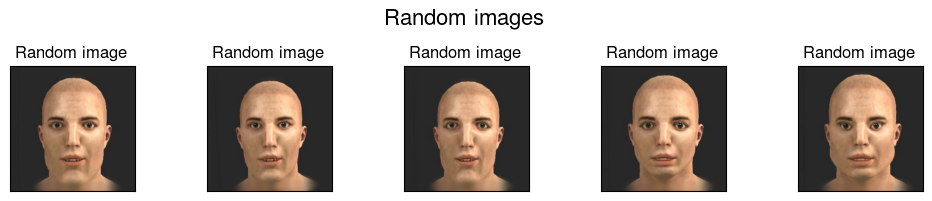

In [6]:
def prepare_5_random_images():
    random_images = np.random.choice(glob(f"{ALIGNED_FOLDER}/*head_genes_*.jpg"), 5)
    print(random_images)
    random_images_tensors = [prep_image(img) for img in random_images]
    return torch.stack(random_images_tensors).to(DEVICE)


In [ ]:

random_images = prepare_5_random_images()
plot_images([prep_tensor_to_show(img) for img in random_images],
            ["Random image" for _ in range(5)],
            1, 5, title="Random images", figsize=[10, 2])


In [70]:

import json

# Convert the list of filepaths to a JSON string
filepaths_json = json.dumps(random_images, indent=4)

# Save the JSON string to a file
with open('random_image_filepaths.json', 'w') as file:
    file.write(filepaths_json)

# Assuming `random_images` is a list of torch.Tensor objects containing the random images

for i, image in enumerate(random_images):
    # Convert the torch.Tensor to a PIL Image
    image_pil = Image.fromarray(image.cpu().numpy())

    # Save the image
    image_pil.save(f"random_image_{i}.jpg")


TypeError: Object of type Tensor is not JSON serializable

: 

In [8]:
random_z = []
for image in random_images:
    print("Another image")
    for _ in range(5):
        print("Starting z")
        z = find_z(image.unsqueeze(0))
        random_z.append(z)



Another image
Starting z
Starting z
Starting z
Starting z
Starting z
Another image
Starting z
Starting z
Starting z
Starting z
Starting z
Another image
Starting z
Starting z
Starting z
Starting z
Starting z
Another image
Starting z
Starting z
Starting z
Starting z
Starting z
Another image
Starting z
Starting z
Starting z
Starting z
Starting z


In [10]:
np.save("random_z.npy", np.array(random_z))
np.array(random_z).shape

(25, 1, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

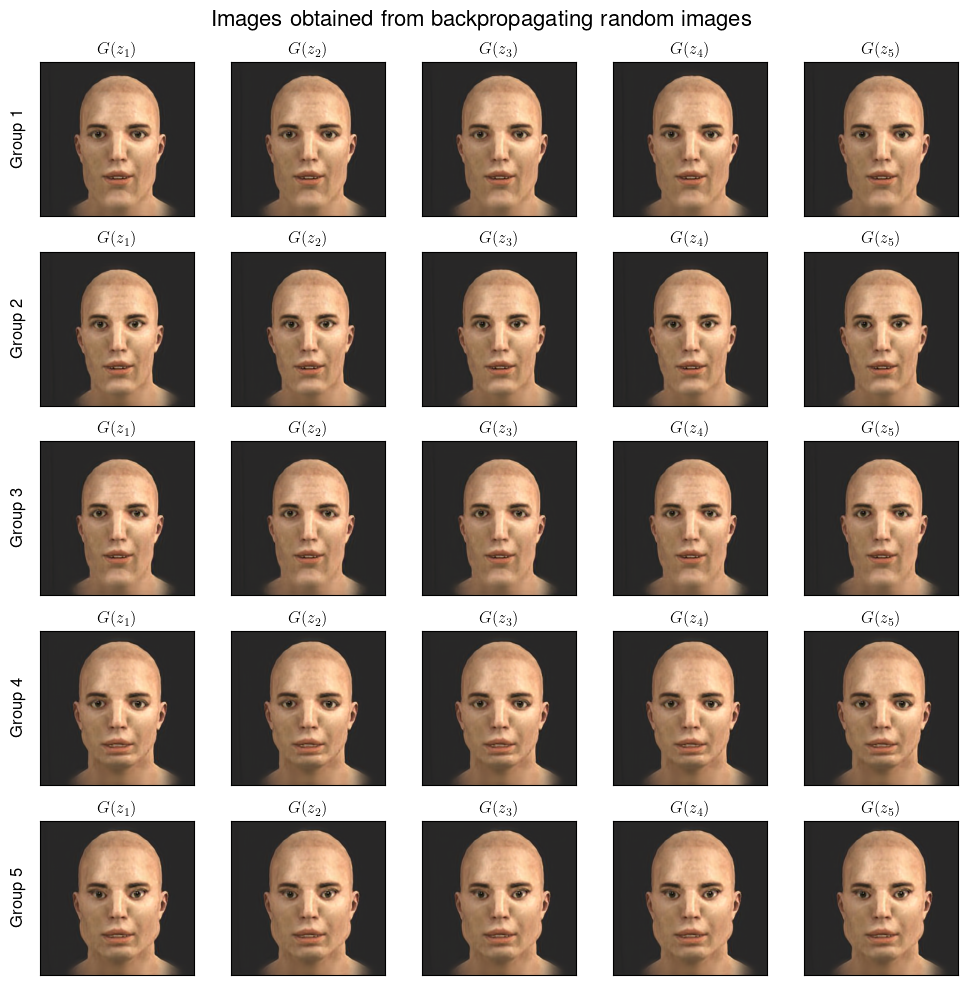

In [52]:
plot_images([prep_tensor_to_show(generator(z.to(DEVICE))[0]) for z in random_z],
            [f"$G(z_{i})$" for _ in range(5) for i in range(1, 6)],
            5, 5, title="Images obtained from backpropagating random images", figsize=[10, 10],
            row_titles=[f"Group {i}" for i in range(1, 6)])

In [21]:
reshaped_z_random = np.array(random_z).reshape(5, 5, 256)

In [22]:
avg_random = np.mean(reshaped_z_random, axis=1)
print(avg_random.shape)
std_random = np.std(np.array(random_z).reshape(5, 5, 256), axis=1)

(5, 256)


In [38]:
random_z_and_avg = np.concatenate([reshaped_z_random.reshape(-1, 256), avg_random], axis=0)

reshaped_z_random_embed = TSNE(n_components=2, perplexity=10).fit_transform(random_z_and_avg)
reshaped_z_random_embed.shape

reshaped_z_embed, avg_z_embed = reshaped_z_random_embed[:-5], reshaped_z_random_embed[-5:]

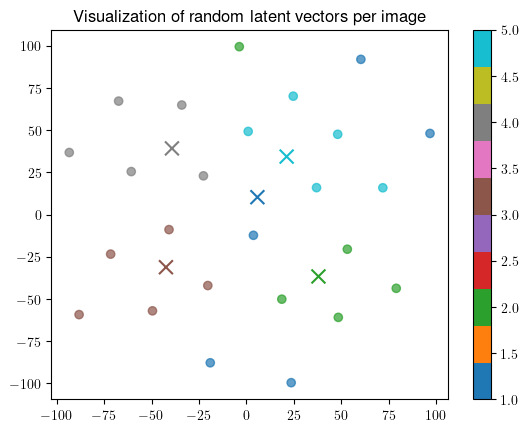

In [60]:
reshaped_z_colors = np.repeat(np.arange(1, 6), 5)
plt.scatter(reshaped_z_embed[:, 0], reshaped_z_embed[:, 1], c=reshaped_z_colors, alpha=0.7, cmap='tab10')

avg_z_colors = np.arange(1, 6)
plt.scatter(avg_z_embed[:, 0], avg_z_embed[:, 1], c=avg_z_colors, alpha=1, marker='x', s=100, cmap='tab10')

# for embedding, average, label in zip(reshaped_z_embed, avg_z_embed, random_labels):
#     plt.scatter(embedding[:, 0], embedding[:, 1], label=label, alpha=0.7)
#     plt.scatter(average[0], average[1], label=label, alpha=0.7, marker='x')

plt.title("Visualization of random latent vectors per image")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


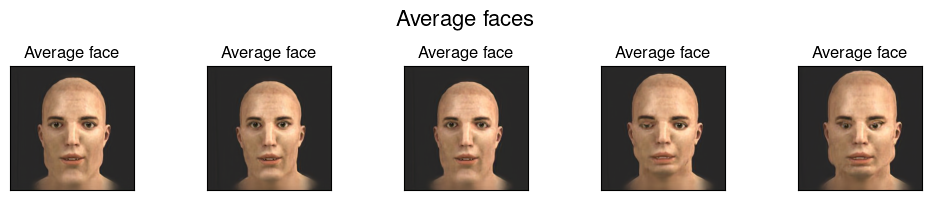

In [67]:

avg_faces = [generator(torch.from_numpy(avg_z).to(DEVICE).unsqueeze(0))[0] for avg_z in avg_random]

# plot_images(random_images, ["Random face" for _ in range(5)], 1, 5, title="Random faces", figsize=[10, 2])
plot_images([prep_tensor_to_show(img) for img in avg_faces], ["Average face" for _ in range(5)], 1, 5, title="Average faces", figsize=[10, 2])